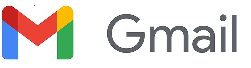

# <div style="text-align: center">Extract Emails from Gmail and convert to Excel</div>

This code -
1. Extracts emails from Gmail from 'Inbox' and 'Spam' folders in .txt format.<br> 
2. Then converts each folder to Excel files.<br>
3. Adds 'spam' and 'non-spam' Labels and 1/0 Label_Numbers.<br>
4. Merges both Excel files into one and shuffles them

**Important Note : enable 'Less Secure App' access for the code to work**<br>
https://myaccount.google.com/lesssecureapps

**Import Libraries**<br>
(install the required packages)

In [8]:
import os, re
import pandas as pd
import codecs
from getpass import getpass
import imaplib, email
from bs4 import BeautifulSoup
from nltk import word_tokenize

**Class emails to download emails**

In [12]:
class emails:
   

    def __init__(self,username,password):
    
        self.mail = imaplib.IMAP4_SSL('imap.gmail.com')
        self.mail.login(username, password)
        self.select_folder('Inbox',True)

    def select_folder(self,folder, read_only):
        self.mail.select(folder,readonly=read_only)

    def get_all_emails(self):
        result,data=self.mail.uid('search',None,'All')
        return result,data[0].decode('utf-8').split()

    def raw_email(self,uid):
        result, data = self.mail.uid('fetch', uid, '(RFC822)')
        return result,data[0][1]


    def __clean__(self,text):
        text = text.replace('  ', ' ')
        text = text.replace('</n', '<')
        text = text.replace('{*}', '')
        #replacing patterns
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'\n+', '\n', text)
        output=''
        words=[word for word in word_tokenize(text) if len(word)<=15 and re.match('[A-Za-z0-9,._]+',word)]
        for word in words:
            if output=='':
                output=word
            else:
                output = output + ' ' + word
        return output

    def parse_email(self,uid):
        dict={}
        result, raw_email = self.raw_email(uid)
        raw_email = raw_email.decode('utf-8','ignore')
        parsed = email.message_from_string(raw_email)
        dict['To']=email.utils.parseaddr(parsed['To'])[-1]
        dict['From']=email.utils.parseaddr(parsed['From'])[-1]
        dict['Subject']=parsed['Subject']

        body=''
        for part in parsed.walk():
            if part.get_content_type()=='text/html':
                html=str(part.get_payload())
                soup = BeautifulSoup(html,'html5lib')
                try:
                    text=soup.find('body').text.strip()
                except Exception:
                    continue

                text=self.__clean__(text)
                body=body + text

        body=self.__clean__(body)
        dict['Body']=body
        return dict
    
    #Directory
    def directory(label):
        cdir =os.getcwd()
        #Setting target folder
        if label.find('/')>0:
            folder=label[label.find('/')+1:].lower()
        else:
            folder=label.lower()
        
        #Create folder, if it does not exist
        if not os.path.exists(cdir + '\Downloads\\' + folder):
            os.mkdir(cdir + '\Downloads\\' + folder)
        return folder
    
    def download_emails(label):
        #Getting all the emails
        mail.select_folder(label,True)
        result, data = mail.get_all_emails()
    
        #Exit, if no emails returned
        if not result=='OK':
            exit(1)

        #Saving the Data
        cdir =os.getcwd()
        print('Downloading ' + emails.directory(label) + ' emails...')
        for uid in data:
            dict = mail.parse_email(uid)
            subject = dict['Subject']
            subject=re.sub('[^a-zA-Z ]','',subject)
            if len(subject) > 50:
                subject = subject[:50]
            file = cdir + '\Downloads\\' + emails.directory(label) + '\\' + subject + '.txt'
            with open(file, 'w', encoding='utf-8') as f:
                body = subject + '\n' + str(dict['Body'])
                f.write(body)
    
        #Status Display
        print('Downloaded ' + emails.directory(label) + ' emails at '+ cdir + '\Downloads\\' + emails.directory(label) + '.')
        print('------------------------------')

        
    #Creates List of Emails
    def create_email_list(folder_path):
        email_list = []
        folder = os.listdir(folder_path)
        for txt in folder:
            file_name = fr'{folder_path}/{txt}'
        
            with codecs.open(file_name, 'r', encoding='utf-8',errors='ignore') as f:
                email = f.read()
                email_list.append(email)
        return email_list

**Input Email ID and Password**

In [10]:
#main
if __name__=='__main__':
    email_id = getpass('Enter Gmail ID :')
    email_password = getpass('Enter Password :')
    mail=emails(email_id,email_password)

Enter Gmail ID :········
Enter Password :········


**Download Spam and Inbox mails from Gmail**

In [13]:
#This might take a while
emails.download_emails('[Gmail]/Spam')
emails.download_emails('INBOX')

Downloaded spam emails at C:\Users\mgman\Downloads\spam.
------------------------------
Downloaded inbox emails at C:\Users\mgman\Downloads\inbox.
------------------------------


**Convert spam emails folder to Excel file**

In [43]:
cdir = os.getcwd()
spam_list = emails.create_email_list(cdir + '\Downloads\\' + emails.directory('[Gmail]/Spam'))
spam_df = pd.DataFrame(spam_list)
spam_df.to_excel(cdir + '\Downloads\spam.xlsx')

print('Converted spam emails to Excel file.')
print('------------------------------')


Converted spam emails to Excel file.
------------------------------


**Convert non spam emails folder to Excel file**

In [44]:
non_spam_list = emails.create_email_list(cdir + '\Downloads\\' + emails.directory('INBOX'))
non_spam_df = pd.DataFrame(non_spam_list)
non_spam_df.to_excel(cdir + '\Downloads\inbox.xlsx')
    
print('Converted inbox emails to Excel file.')
print('------------------------------')

Converted inbox emails to Excel file.
------------------------------


In [45]:
#read both files
df1 = pd.read_excel(cdir + '\Downloads\inbox.xlsx')
df2 = pd.read_excel(cdir + '\Downloads\spam.xlsx')

In [46]:
df1.columns

Index(['Unnamed: 0', 0], dtype='object')

In [47]:
df2.columns

Index(['Unnamed: 0', 0], dtype='object')

**Add 'non_spam' Label and 0 Label_Number to non spam file**

In [48]:
df1.insert(1,"Label", "non_spam")
df1.insert(3,"Label_Number", 0)
df1.rename(columns = {'Unnamed: 0': 'ID',0: 'Text'}, inplace = True)
df1.head()

,ID,Label,Text,Label_Number
0,0,non_spam,BHK Apartments in North Goa Rs Lakh Onwar...,0
1,1,non_spam,BHK Apt starts From Lakh With Free Registr...,0
2,2,non_spam,BHK Ready to Move in Apartments in Raj Naga...,0
3,3,non_spam,BHK Apt Starts From Rs Lakhs With Free Regi...,0
4,4,non_spam,BHK Luxury Ready to Move Apartments Rs Lakh ...,0


**Add 'spam' Label and 1 Label_Number to spam file**

In [49]:
df2.insert(1,"Label", "spam")
df2.insert(3,"Label_Number", 1)
df2.rename(columns = {'Unnamed: 0': 'ID',0: 'Text'}, inplace = True)
df2.head()

,ID,Label,Text,Label_Number
0,0,spam,"Activity Sheet_x000D_\nDear Rupal , Hello , I ...",1
1,1,spam,Advertise your property till it gets rented ou...,1
2,2,spam,Application Fee Waiver Apply to St Lawrence C...,1
3,3,spam,Apply for Nipissing University Canada For Sep ...,1
4,4,spam,Apply for Northern College at Pures Toronto f...,1


**Merge spam and non spam Excel files in one and shuffle**

In [68]:
df_all = pd.concat([df1, df2])
df_all.reset_index(inplace=True, drop=True) 
df_all.pop('ID')
df_final = df_all.sample(frac = 1)
df_final.reset_index(inplace=True, drop=True) 
df_final

,Label,Text,Label_Number
0,spam,Why United Kingdom is best study destination_x...,1
1,non_spam,Homeowners are looking for a tenant like you z...,0
2,non_spam,Shop Assigned Mi Home VM JanakpuriHigh Street...,0
3,non_spam,Profile picture pending approval_x000D_\nHi Ru...,0
4,non_spam,Mahimagoyal JEE Main New Exam Dates Out_x000D_\n,0
...,...,...,...
975,non_spam,UTFBKSoKSPIOCkuOCkpuCkuOCljeCkryE_x000D_\nmahi...,0
976,non_spam,UTFBUnMgMTUwICgKSKSwKWNKSKWHIOCkruClhCkgiDgpKg...,0
977,non_spam,Mahima Your request is now registered with us_...,0
978,non_spam,UTFBTWFoaWhZYWwsIEhpZhlcQgUGFjaFnZSAIElOUiAxNS...,0


**Enter the name of Excel file and Download final dataset**

In [70]:
excel_file_name = input("Enter name of Excel File: ")
df_final.to_excel(cdir + '\Downloads\\'+excel_file_name + '.xlsx')
print('Downloaded all emails dataset in '+ cdir +  '\Downloads\\'+excel_file_name + '.xlsx')
print('------------------------------')

Enter name of Excel File: All_Emails
Downloaded all emails dataset in C:\Users\mgman\Downloads\All_Emails.xlsx
------------------------------
